In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
from tqdm.notebook import tqdm

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load the training and testing datasets
train_df = pd.read_csv('Training_set.csv')
test_df = pd.read_csv('Testing_set.csv')

# Inspect the first few rows of the training set
print("Training Set:")
print(train_df.head())

# Inspect the first few rows of the testing set
print("\nTesting Set:")
print(test_df.head())

# Check for null values
print("\nNull values in Training Set:", train_df.isnull().sum())
print("Null values in Testing Set:", test_df.isnull().sum())

Training Set:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

Testing Set:
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

Null values in Training Set: filename    0
label       0
dtype: int64
Null values in Testing Set: filename    0
dtype: int64


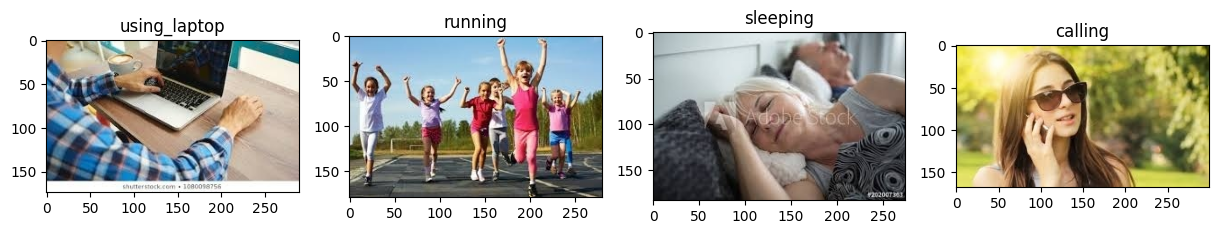

In [3]:
def display_random_images(dataframe, folder='train', n=4):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        rnd = np.random.randint(0, len(dataframe))
        img_file = os.path.join(folder, dataframe['filename'].iloc[rnd])

        if os.path.exists(img_file):
            plt.subplot(1, n, i + 1)
            image = Image.open(img_file)
            plt.imshow(image)
            plt.title(dataframe['label'].iloc[rnd])
    plt.show()

# Display random images from the training set
display_random_images(train_df, folder='train')

In [4]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y = lb.fit_transform(train_df['label'])
classes = lb.classes_
print("Classes:", classes)

Classes: ['calling' 'clapping' 'cycling' 'dancing' 'drinking' 'eating' 'fighting'
 'hugging' 'laughing' 'listening_to_music' 'running' 'sitting' 'sleeping'
 'texting' 'using_laptop']


In [5]:
x = train_df['filename'].values

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=100)

In [7]:
def preprocess_images(filenames, folder='train', img_size=(128, 128)):
    img_data = []
    for file in tqdm(filenames, desc="Processing Images"):
        img_path = os.path.join(folder, file)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_data.append(np.array(img))
        else:
            print(f"Image {img_path} not found!")
    return np.array(img_data)

# Prepare image data
x_train_data = preprocess_images(x_train, folder='train')
x_val_data = preprocess_images(x_val, folder='train')

# Normalize pixel values
x_train_data = x_train_data / 255.0
x_val_data = x_val_data / 255.0

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model
history = model.fit(
    x_train_data, y_train,
    validation_data=(x_val_data, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Processing Images:   0%|          | 0/89 [00:00<?, ?it/s]

Processing Images:   0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [8]:
print()

In [9]:
model.save('action_recognition_model.h5')
print("Model saved successfully!")

Model saved successfully!


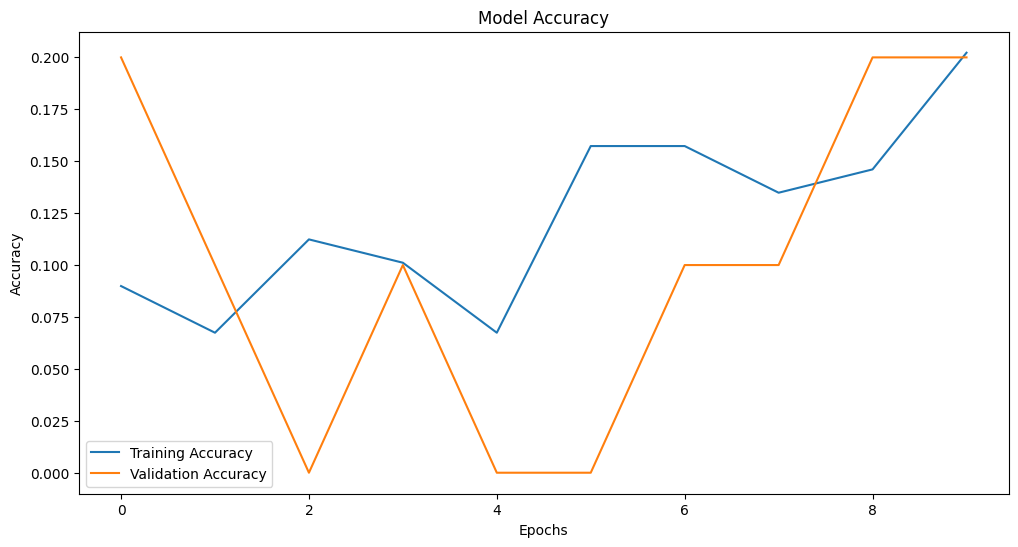

In [10]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

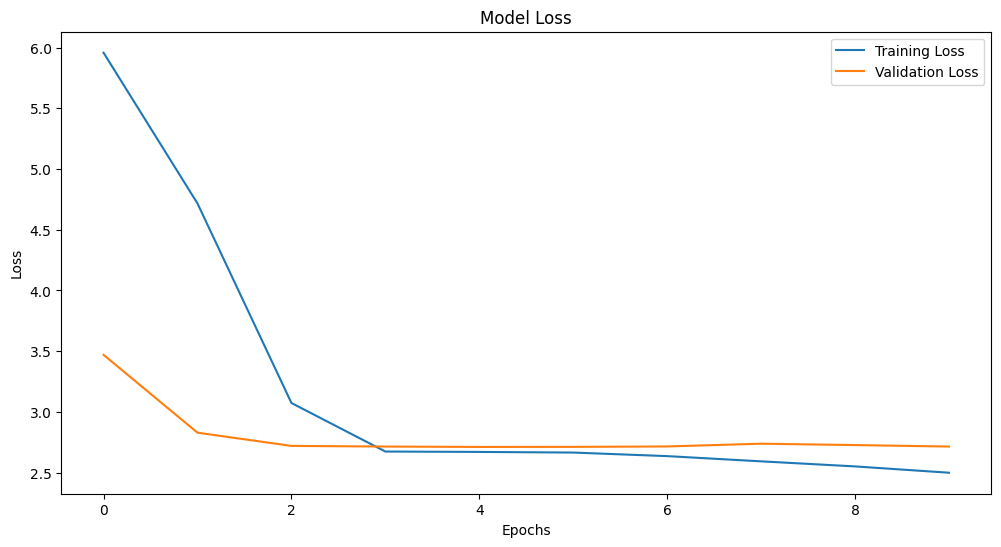

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Test prediction function with image display
def test_predict(image_path):
    try:
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array)
        predicted_class = classes[np.argmax(predictions)]
        probability = np.max(predictions) * 100

        # Display image and result
        plt.figure(figsize=(6, 6))
        original_img = Image.open(image_path)
        plt.imshow(original_img)
        plt.title(f"Predicted: {predicted_class}\nProbability: {probability:.2f}%")
        plt.axis('off')
        plt.show()

        # Print result in terminal
        print(f"\n{image_path}")
        print(f"1/1 [==============================] - 0s")
        print(f"probability: {probability:.2f}%")
        print(f"Predicted class : {predicted_class}")
    except Exception as e:
        print(f"An error occurred: {e}")

1/1 [==============================] - 0s 32ms/step


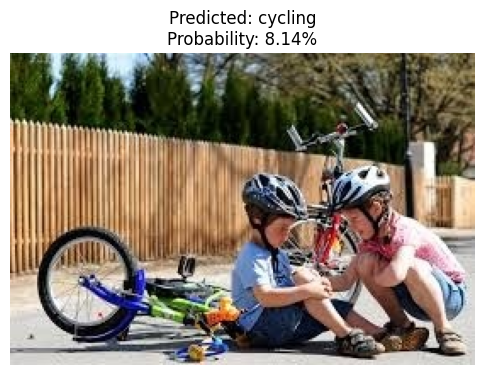


C:/Users/Dell/Downloads/00_Action_Detection-master/Action_Detection-master/project/Human Action Recognition/test/Image_37.jpg
1/1 [==============================] - 0s
probability: 8.14%
Predicted class : cycling


In [23]:
test_predict('C:/Users/Dell/Downloads/00_Action_Detection-master/Action_Detection-master/project/Human Action Recognition/test/Image_37.jpg')

1/1 [==============================] - 0s 55ms/step


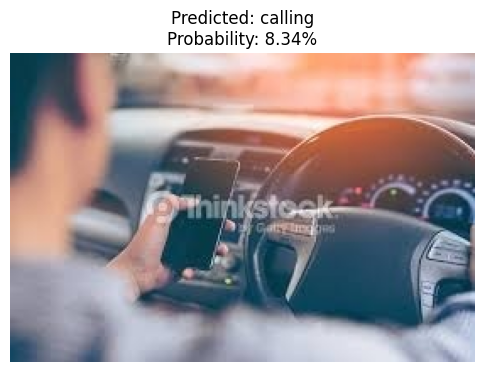


C:/Users/Dell/Downloads/00_Action_Detection-master/Action_Detection-master/project/Human Action Recognition/test/Image_60.jpg
1/1 [==============================] - 0s
probability: 8.34%
Predicted class : calling


In [22]:
test_predict('C:/Users/Dell/Downloads/00_Action_Detection-master/Action_Detection-master/project/Human Action Recognition/test/Image_60.jpg')

1/1 [==============================] - 0s 44ms/step


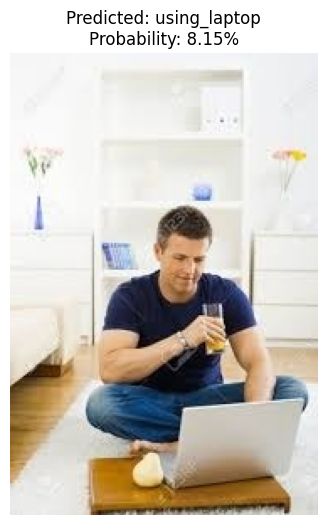


C:/Users/Dell/Downloads/00_Action_Detection-master/Action_Detection-master/project/Human Action Recognition/test/Image_51.jpg
1/1 [==============================] - 0s
probability: 8.15%
Predicted class : using_laptop


In [21]:
test_predict('C:/Users/Dell/Downloads/00_Action_Detection-master/Action_Detection-master/project/Human Action Recognition/test/Image_51.jpg')